# 프로젝트: 고양이 수염 스티커 만들기
---
## 고양이 수염 이미지 적용하기
- 이미지로 부터 얼굴 정보를 검출하는 함수 구현
- 원본 이미지 얼굴에 스티커 이미지를 합성하는 함수 구현
---
### 주요 라이브러리 버전

In [135]:
# 필요한 패키지 import 하기
import math
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

print('cv2 version:', cv2.__version__)
print('dlib version:', dlib.__version__)

cv2 version: 4.8.0
dlib version: 19.24.0


### 이미지 불러오기

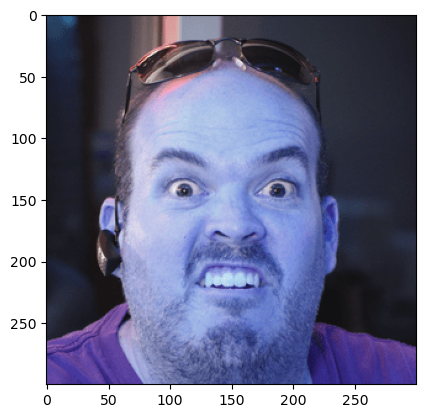

In [136]:
# opencv는 BGR (파랑, 녹색, 빨강) 이미지 채널을 사용한다.
'''
cv2.imread(fileName, flag)
    flag
    - cv2.IMREAD_COLOR (1) : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시 (Default)
    - cv2.IMREAD_GRAYSCALE (0) : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
    - cv2.IMREAD_UNCHANGED (-1) : 이미지파일을 alpha channel까지 포함하여 읽어 
'''
img_bgr = cv2.imread('./images/face01.jpg') # OpenCV로 이미지를 불러옵니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

### 이미지 RGB 출력

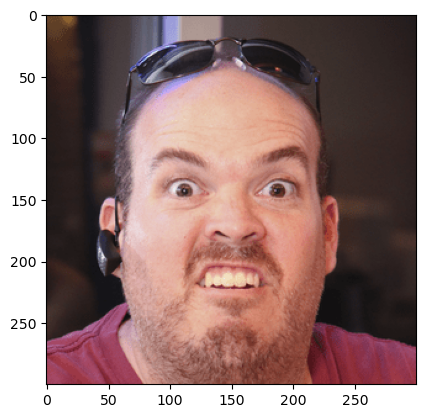

In [137]:
'''
matplotlib 라이브러리는 RGB(빨강, 녹색, 파랑) 이미지 채널을 사용하므로 출력하려면 색깔 보정 처리 필요
cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    - cv2.COLOR_BGR2RGB : BGR 이미지를 RGB로 변환
'''
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) 
plt.show() # 이미지 출력

### 얼굴 검출 (face detection)
dlib의 face detector를 사용하여 얼굴 위치 검출

얼굴 검출 수: 1
=========== face 0 ===============
left: 56
top: 77
right: 242
bottom: 263
width: 187
height: 187


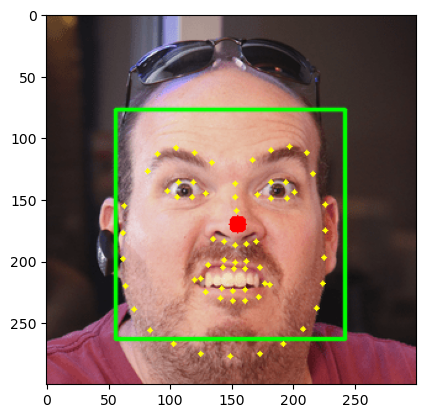

In [138]:
'''
detector_hog
    기본 얼굴 감지기
    dlib.get_frontal_face_detector 함수를 이용하여 모델을 불러옴    
''' 
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기
'''
landmark_predictor
    RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    dlib.shape_predictor 함수를 이용하여 모델을 불러옴
'''
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')
####################################################################################
# 얼굴 정보 반환 함수
'''
    show_landmark=True 호출 : landmark 검출 이미지 출력
'''
####################################################################################
# 얼굴 bounding box, landmark, 코 위치 이미지 출력 확인
def get_face_info(img_src, num_pyramid=1, show_landmark=False):
    # detector_hog를 이용해서 얼굴의 bounding box를 추출
    dlib_rects = detector_hog(img_src, num_pyramid)   # (image, num of image pyramid)
    '''
    detector_hog 두 번째 파라미터 : 이미지 피라미드의 수
        이미지 피라미드 : 이미지를 upsampling 방법을 통해 크기를 키우는 것
        이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 
    '''
    face_cnt= len(dlib_rects)
    print('얼굴 검출 수:', face_cnt)
    
    # 얼굴 정보 검출 함수
    def _get_one_info(img_src, dlib_rect):
        
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
        w = dlib_rect.width() # 가로 픽셀
        h = dlib_rect.height() # 세로 픽셀
        print('left:',l)
        print('top:', t)
        print('right:', r)
        print('bottom:', b)  
        print('width:', w)  
        print('height:', h)
        
        # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
        if show_landmark:
            cv2.rectangle(img_src, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) 
        
        # landmark의 위치정보 검출
        points = landmark_predictor(img_src, dlib_rect)
        landmark = list(map(lambda p: (p.x, p.y), points.parts()))
        if show_landmark:
            for point in landmark:
                cv2.circle(img_src, point, 2, (0, 255, 255), -1)            
            # 코 위치는 30번
            cv2.circle(img_landmark, landmark[30], 2, (0, 0, 255), 10)
            
        # 코 각도 계산
        p1 = landmark[30]
        p2 = landmark[27]
        vec = (p2[0] - p1[0], p2[1] - p1[1])
        isNegX = vec[0] < 0
        isNegY = vec[1] < 0
        nose_deg =0
        if vec[0] == 0:
            nose_deg = 90
            if isNegY:
                nose_deg = -90
        elif vec[1] == 0:
            nose_deg = 0
            if isNegX:
                nose_deg = 180
        else:       
            # x,y 양의 영역으로 각도 계산
            x = abs(vec[0])
            y = abs(vec[1])
            rad = math.atan(y / x)
            deg = math.degrees(rad)
            if isNegX & isNegY:
                nose_deg = 180 + deg
            elif isNegX:
                nose_deg = 180 - deg
            elif isNegY:
                nose_deg = deg * -1
            else:
                nose_deg = deg
            
        return {
            # 'left': l,
            # 'top': t,
            # 'right': r,
            # 'bottom': b,
            'width': w,
            'height': h,
            # 'landmark': landmark,
            'nose': landmark[30],
            'nose-degree': nose_deg * -1
        }
        
    # 얼굴 정보(반환값) 저장 리스트
    result = []
    
    # landmark 출력용 이미지 복사
    img_landmark = img_src.copy()
    for i in range(face_cnt):
        # 여러 얼굴이 있을 수 있습니다
        print('=========== face {} ==============='.format(i))        
        # 얼굴 정보 검출 및 출력용 이미지에 표기
        temp = _get_one_info(img_landmark, dlib_rects[i])
        # 얼굴 정보 저장
        result.append(temp)
    if show_landmark:
        # landmark 표기 이미지 출력
        plt.imshow(cv2.cvtColor(img_landmark, cv2.COLOR_BGR2RGB))
        plt.show()
    
    return result
####################################################################################        

# 이미지로부터 얼굴들의 정보 검출
info = get_face_info(img_bgr, show_landmark=True)

### 고양이 스티커 적용하기

얼굴 검출 수: 1
=========== face 0 ===============
left: 56
top: 77
right: 242
bottom: 263
width: 187
height: 187


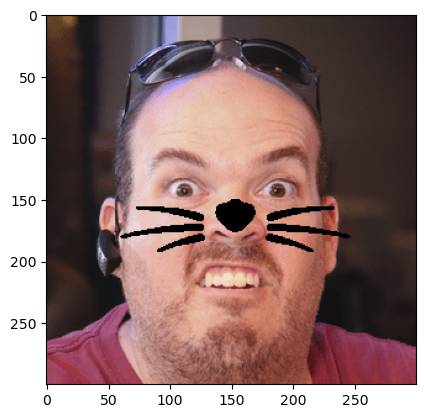

In [139]:
####################################################################################
# 스티커 합성 함수
'''원본 이미지 얼굴의 코 위치에 스티커 이미지 합성'''
####################################################################################
def put_sticker_on_face(img, stiker, num_pyramid=1, show_landmark=False):
    return_img = img.copy()
    # 얼굴 정보 추출
    info_list = get_face_info(return_img, num_pyramid, show_landmark)
    # 얼굴에 스티커 적용
    for info in info_list:
        # 얼굴 정보
        w = info['width']
        h = info['height']
        nose_point = info['nose']
        # 스티커 이미지 복사
        temp_sticker = stiker.copy()
        # 얼굴 크기로 사이즈 조정
        temp_sticker = cv2.resize(temp_sticker, (w,h)) 
        # 스티커 이미지 위치 x, y 좌표 설정 : 코 위치로 부터 이미지 시작 위치 설정
        x = nose_point[0] - (w // 2)
        y = nose_point[1] - (h // 2)
        # 스티커 위치가 원본을 벗어 나는 경우 이미지 및 위치 조정
        if x < 0: 
            temp_sticker = temp_sticker[:, -x:]
            x = 0
        if y < 0:
            # ex> y가 -98이면, temp_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
            temp_sticker = temp_sticker[-y:, :] 
            y = 0
        sticker_area = return_img[y:y+temp_sticker.shape[0], x:x+temp_sticker.shape[1]]
        
        return_img[y:y+temp_sticker.shape[0], x:x+temp_sticker.shape[1]] = \
            np.where(temp_sticker!=0, sticker_area, temp_sticker).astype(np.uint8)
    
    return return_img
####################################################################################
# 스티커 이미지를 불러옵니다
img_sticker = cv2.imread('./images/cat-whiskers.png')

# 원본 이미지 얼굴에 스티커 붙인 이미지 생성 및 출력
img_result = put_sticker_on_face(img_bgr, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴 여러개 이미지 테스트

얼굴 검출 수: 2
=========== face 0 ===============
left: 98
top: 47
right: 253
bottom: 202
width: 156
height: 156
=========== face 1 ===============
left: 268
top: 82
right: 397
bottom: 211
width: 130
height: 130


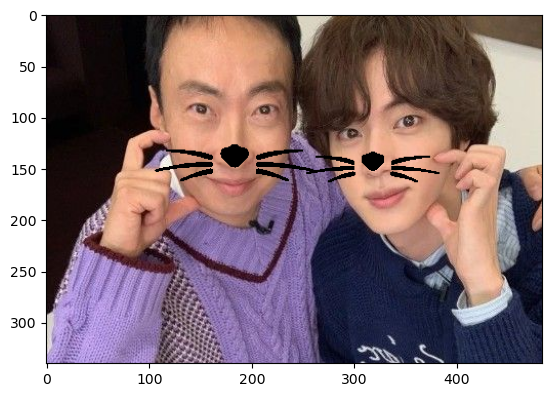

In [140]:
img_two = cv2.imread('./images/twoshot.jpg')
img_result = put_sticker_on_face(img_two, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

## 기울어진 얼굴 검출하기

얼굴 검출 수: 0


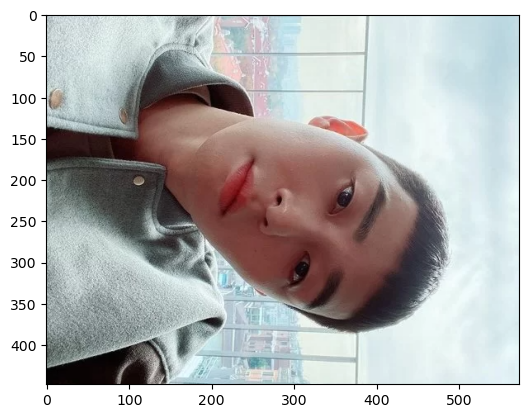

In [141]:
img_face02 = cv2.imread('./images/face02.png')
img_result = put_sticker_on_face(img_face02, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

- 기울어진 얼굴은 검출하지 못한다.
- 개선 방안: 이미지를 회전하며 검출 후 스티커 적용시키기

원본 - 얼굴 검출 수: 0
90도 회전 - 얼굴 검출 수: 0
180도 회전 - 얼굴 검출 수: 0
270도 회전 - 얼굴 검출 수: 1
=========== face 0 ===============
left: 117
top: 167
right: 340
bottom: 390
width: 224
height: 224


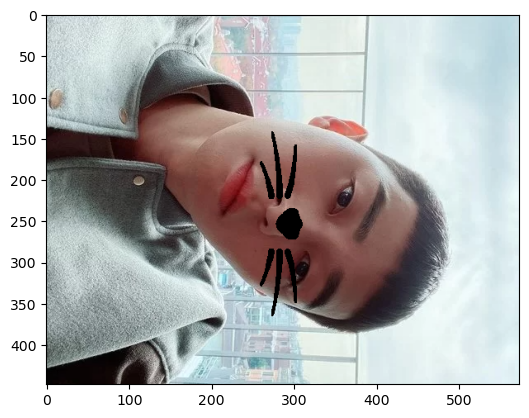

In [142]:
def put_sticker_on_face_all(img, sticker):
    # 원본 검출
    print('원본 -', end=' ')
    img_temp = put_sticker_on_face(img, sticker)
    # 90도씩 3번 회전하며 검출    
    for i in range(1,4):
        deg = i * 90
        print('{}도 회전 -'.format(deg), end=' ')        
        img_temp = cv2.rotate(img_temp, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전    
        img_temp = put_sticker_on_face(img_temp, sticker)
    return cv2.rotate(img_temp, cv2.ROTATE_90_CLOCKWISE)

img_result = put_sticker_on_face_all(img_face02, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

- 약간 삐뚤어 졌는데 더 작은 단위로 회전하며 검출하면??
- 45도 단위로 회전 테스트

원본 - 얼굴 검출 수: 0
45도 회전 - 얼굴 검출 수: 0
90도 회전 - 얼굴 검출 수: 1
=========== face 0 ===============
left: 191
top: 118
right: 414
bottom: 341
width: 224
height: 224
135도 회전 - 얼굴 검출 수: 0
180도 회전 - 얼굴 검출 수: 0
225도 회전 - 얼굴 검출 수: 0
270도 회전 - 얼굴 검출 수: 0
315도 회전 - 얼굴 검출 수: 0


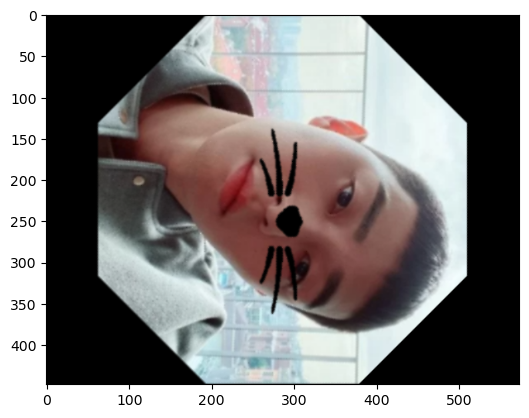

In [143]:
def put_sticker_on_face_all(img, sticker):
    # 원본 검출
    print('원본 -', end=' ')
    img_temp = put_sticker_on_face(img, sticker)    
    
    # 45도 회전 metrix
    (h, w) = img_temp.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), 45, 1.0)
    
    # 45도씩 7번 회전하며 검출
    for i in range(1,8):
        deg = i * 45
        print('{}도 회전 -'.format(deg), end=' ')
        # 이미지 회전 및 스티커 적용
        img_temp = cv2.warpAffine(img_temp, M, (w, h))
        img_temp = put_sticker_on_face(img_temp, sticker)
    return cv2.warpAffine(img_temp, M, (w, h))

img_result = put_sticker_on_face_all(img_face02, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

- 회전하면서 이미지 짤리는 문제가 생김
- 135도에서 검출되기 바랬지만 90도 회전과 동일한 결과

얼굴 검출 수: 1
=========== face 0 ===============
left: 191
top: 93
right: 414
bottom: 316
width: 224
height: 224


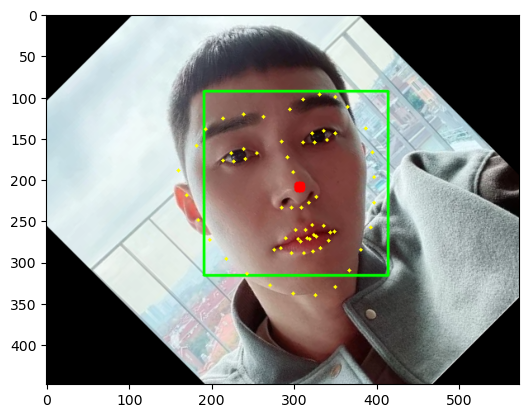

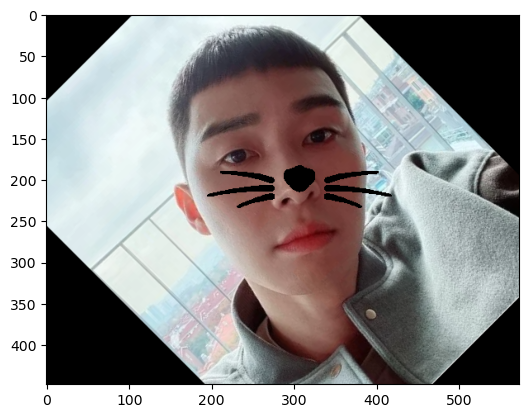

얼굴 검출 수: 0


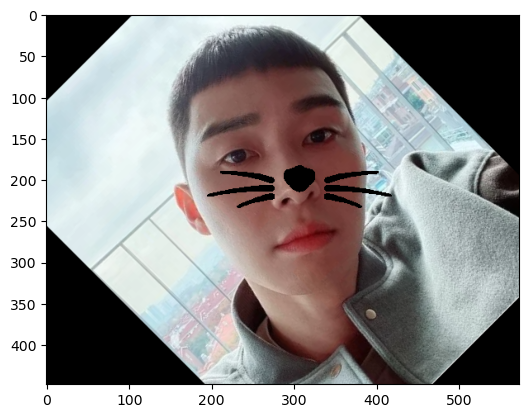

[]

In [144]:
# 135도 검출 테스트
(h, w) = img_face02.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), 135, 1.0)
img_result = cv2.warpAffine(img_face02, M, (w, h))
img_result = put_sticker_on_face(img_result, img_sticker, show_landmark=True)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

# 135도 스티커 적용 후 얼굴 검출 테스트
get_face_info(img_result, show_landmark=True)

- 135도에서 검출은 된다...
- 스티커 적용 후 이미지에서 얼굴 검출이 안되는 듯
- 회전 하면서 스티커 적용 시 먼저 적용된 각도로 적용됨
- 개선 방안: 모든 각도에서 검출 후 가장 잘 적용된 각도 선정??
- 회전 시 이미지 손실 문제...

### 회전 및 바운딩 처리 테스트

원본 - 얼굴 검출 수: 0
45도 회전 - 얼굴 검출 수: 0
90도 회전 - 얼굴 검출 수: 0


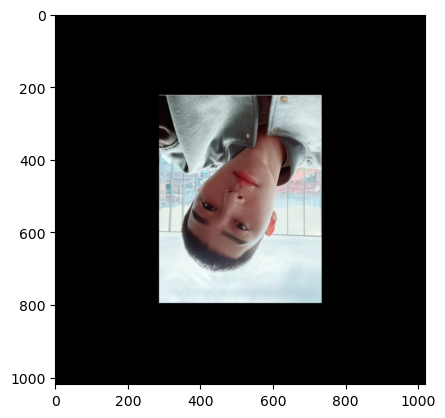

In [145]:
import imutils
'''
imutils.rotate_bound : 이미지 회전 및 바운딩 처리
'''
def put_sticker_on_face_all(img, sticker):
    # 원본 검출
    print('원본 -', end=' ')
    img_temp = put_sticker_on_face(img, sticker)
    
    # 45도씩 회전하며 검출 일단 두번만
    deg = 45    
    for i in range(1,3):
        print('{}도 회전 -'.format(i * deg), end=' ')
        # 이미지 회전 및 스티커 적용
        img_temp = imutils.rotate_bound(img_temp, deg)
        img_temp = put_sticker_on_face(img_temp, sticker)
    return img_temp

img_result = put_sticker_on_face_all(img_face02, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

- 회전 및 바운딩 시 이미지 손실 문제
- 이미지가 작아지면서 검출 속도가 오래 걸리는 문제 발생
---
### 개선 방안 변경
- 90도 회전하며 얼굴 검출
- 얼굴 정보에 코 각도 계산 반환 처리
- 랜드마크에서 코의 각도를 계산하여 스티커를 회전 적용하기

얼굴 검출 수: 1
=========== face 0 ===============
left: 191
top: 118
right: 414
bottom: 341
width: 224
height: 224


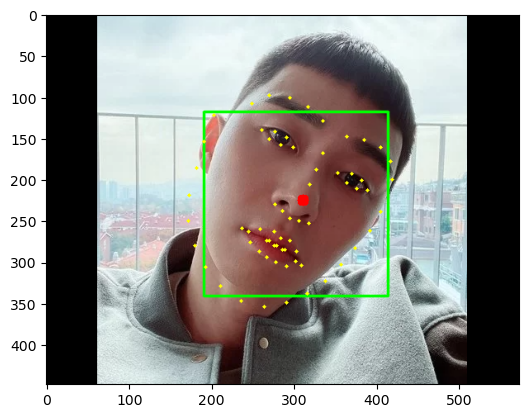

[{'width': 224, 'height': 224, 'nose': (311, 225), 'nose-degree': 67.16634582208245}]


In [146]:
# 90도 검출 테스트
(h, w) = img_face02.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), 90, 1.0)
img_result = cv2.warpAffine(img_face02, M, (w, h))
face_info = get_face_info(img_result, show_landmark=True)
print(face_info)

### 코 각도로 스티커 회전 테스트
- 이미지 합성 함수에 적용

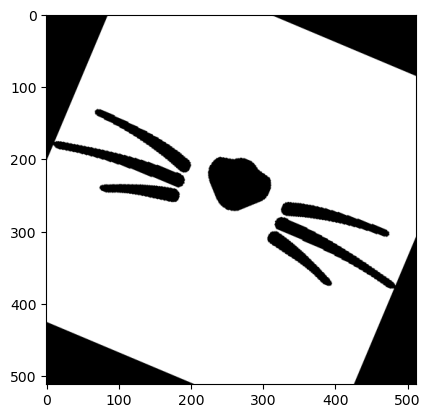

In [147]:
# (코각도 - 90)도 로 스티커 회전
nose_deg = face_info[0]['nose-degree']
(h, w) = img_sticker.shape[:2]
(cX, cY) = (w // 2, h // 2)
M = cv2.getRotationMatrix2D((cX, cY), nose_deg - 90, 1.0)
rotation_sticker = cv2.warpAffine(img_sticker, M, (w, h))
plt.imshow(cv2.cvtColor(rotation_sticker, cv2.COLOR_BGR2RGB))
plt.show()


### 이미지 합성 함수 수정
- 90도씩 회전하며 얼굴 검출
- 검출한 얼굴의 각도로 스티커를 회전시켜 합성

원본 - 얼굴 검출 수: 0
90도 회전 - 얼굴 검출 수: 0
180도 회전 - 얼굴 검출 수: 0
270도 회전 - 얼굴 검출 수: 1
=========== face 0 ===============
left: 117
top: 167
right: 340
bottom: 390
width: 224
height: 224


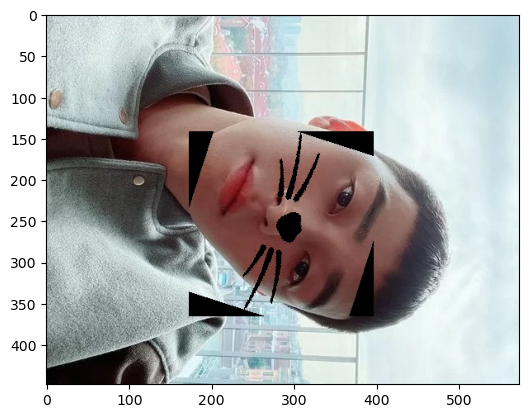

In [149]:
####################################################################################
# 스티커 합성 함수
def put_sticker_on_face(img, stiker, num_pyramid=1, show_landmark=False):
    return_img = img.copy()
    # 얼굴 정보 추출
    info_list = get_face_info(return_img, num_pyramid, show_landmark)
    # 얼굴에 스티커 적용
    for info in info_list:
        # 얼굴 정보
        w = info['width']
        h = info['height']
        nose_point = info['nose']
        nose_deg = info['nose-degree']
        
        # 스티커 이미지 복사
        temp_sticker = stiker.copy()
        
        # 얼굴 크기로 사이즈 조정
        temp_sticker = cv2.resize(temp_sticker, (w,h))
        
        # 스티커 얼굴 각도로 회전        
        (h, w) = temp_sticker.shape[:2]
        (cX, cY) = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D((cX, cY), nose_deg - 90, 1.0)
        temp_sticker = cv2.warpAffine(temp_sticker, M, (w, h))
        
        # 스티커 이미지 위치 x, y 좌표 설정 : 코 위치로 부터 이미지 시작 위치 설정
        x = nose_point[0] - (w // 2)
        y = nose_point[1] - (h // 2)
        # 스티커 위치가 원본을 벗어 나는 경우 이미지 및 위치 조정
        if x < 0: 
            temp_sticker = temp_sticker[:, -x:]
            x = 0
        if y < 0:
            # ex> y가 -98이면, temp_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
            temp_sticker = temp_sticker[-y:, :] 
            y = 0
        sticker_area = return_img[y:y+temp_sticker.shape[0], x:x+temp_sticker.shape[1]]
        
        return_img[y:y+temp_sticker.shape[0], x:x+temp_sticker.shape[1]] = \
            np.where(temp_sticker!=0, sticker_area, temp_sticker).astype(np.uint8)
    
    return return_img
####################################################################################
def put_sticker_on_face_all(img, sticker):
    # 원본 검출
    print('원본 -', end=' ')
    img_temp = put_sticker_on_face(img, sticker)
    # 90도씩 3번 회전하며 검출    
    for i in range(1,4):
        deg = i * 90
        print('{}도 회전 -'.format(deg), end=' ')        
        img_temp = cv2.rotate(img_temp, cv2.ROTATE_90_CLOCKWISE) # 시계방향으로 90도 회전    
        img_temp = put_sticker_on_face(img_temp, sticker)
    return cv2.rotate(img_temp, cv2.ROTATE_90_CLOCKWISE)

img_result = put_sticker_on_face_all(img_face02, img_sticker)
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.show()

아...스티커 바인딩 문제...